# K-Means Clustering

We will use the unsupervised learning ML technique of K-Means clustering, where we seek to identity primary groups of papers where their cluster is unknown. K-Means also provides us a method for *feature engineering* where it's desirable to create more predictors to increase accuracy of our model.

In [1]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
import pandas as pd
import math
import seaborn as sns

In [96]:
# Change data_dir to folder on your computer.
data_dir = "../data/"
filepath = data_dir+"paper_ranks.csv"
num_clusters = 9
text_columns = ['paper_id'] # 
numeric_columns = ['AuthorRank', 'JournalRank', 'Recency', 'CitedAuthorsRank', 'CitedInstitutionRank', \
                   'q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'q08', 'q09']
model_data = None
logical_cores = 4 # how many logical CPU cores you have

In [97]:
# Functions
def normalize(df):
    """
    Normalize and Scale the numerical columns
    """
    data = df.copy().values   
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_data = min_max_scaler.fit_transform(data)
    return pd.DataFrame(columns=df.columns, data=scaled_data)

def plot_scree(percent_variance):
    """
    Create Scree Plot of Principal Components Variance
    """  
    # Visualize the variance explained for each observation by the principal components
    cols = []
    for i in range(len(percent_variance)):
        cols.append('PC'+str(i+1))

    sns.barplot(y=cols, x=percent_variance)
    plt.title('PCA Scree Plot - larger explains more variance')
    plt.show()

In [98]:
# Import XDF Online Retail data set
df = pd.read_csv(filepath)
df = df.drop('q10', 1)
df = df.fillna(1)
df.head()

,paper_id,AuthorRank,JournalRank,Recency,CitedAuthorsRank,CitedInstitutionRank,q01,q02,q03,q04,q05,q06,q07,q08,q09
0,000a9d20ef42c288254c8e631056693b8e3b5498,1.00000,0.00000,1.00000,1.00000,1.0,0.0,0.0,0.00389,0.000,1.0,0.00000,0.00000,0.0,0.00000
1,000b7d1517ceebb34e1e3e817695b6de03e2fa78,0.02300,0.00164,0.92796,1.00000,1.0,0.0,0.0,0.00778,0.000,1.0,0.00000,0.00000,0.0,0.00000
2,0012e9e7414d62c560dd8da14415c4803fc8674e,1.00000,0.00000,1.00000,1.00000,1.0,0.0,0.0,0.00000,0.000,1.0,0.00000,0.00000,0.0,0.00000
3,00142f93c18b07350be89e96372d240372437ed9,1.00000,0.00000,0.92031,0.14355,1.0,0.0,0.0,0.06615,0.075,1.0,0.01852,0.01754,0.0,0.01852
4,0015023cc06b5362d332b3baf348d11567ca2fbb,0.02515,0.00000,0.98550,0.00541,1.0,0.0,0.0,0.04669,0.000,1.0,0.00000,0.00000,0.0,0.00000


In [99]:
df.describe()

,AuthorRank,JournalRank,Recency,CitedAuthorsRank,CitedInstitutionRank,q01,q02,q03,q04,q05,q06,q07,q08,q09
count,29478.000000,29478.000000,29478.000000,29478.000000,29478.000000,29478.000000,29478.000000,29478.000000,29478.000000,29478.0,29478.000000,29478.000000,29478.000000,29478.000000
mean,0.864309,0.000163,0.948375,0.610514,0.960700,0.009104,0.006109,0.030879,0.004812,1.0,0.006358,0.007018,0.001405,0.006024
std,0.331141,0.008242,0.067313,0.454842,0.191518,0.033521,0.027612,0.066129,0.027560,0.0,0.023408,0.026505,0.010424,0.022880
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.917240,0.076140,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.973560,1.000000,1.000000,0.000000,0.000000,0.007780,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000060,1.000000,1.000000,1.000000,0.005460,0.000000,0.027240,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [114]:
model_df = df.copy().drop('paper_id', 1)
# Normalize data
model_df = normalize(model_df)
model_df.head()

,AuthorRank,JournalRank,Recency,CitedAuthorsRank,CitedInstitutionRank,q01,q02,q03,q04,q05,q06,q07,q08,q09
0,1.00000,0.00000,1.00000,1.00000,1.0,0.0,0.0,0.00389,0.000,0.0,0.00000,0.00000,0.0,0.00000
1,0.02300,0.00164,0.92796,1.00000,1.0,0.0,0.0,0.00778,0.000,0.0,0.00000,0.00000,0.0,0.00000
2,1.00000,0.00000,1.00000,1.00000,1.0,0.0,0.0,0.00000,0.000,0.0,0.00000,0.00000,0.0,0.00000
3,1.00000,0.00000,0.92031,0.14355,1.0,0.0,0.0,0.06615,0.075,0.0,0.01852,0.01754,0.0,0.01852
4,0.02515,0.00000,0.98550,0.00541,1.0,0.0,0.0,0.04669,0.000,0.0,0.00000,0.00000,0.0,0.00000


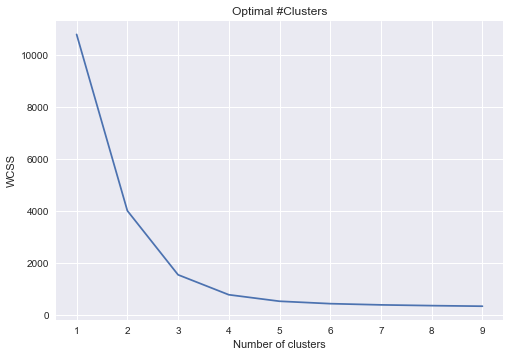

In [155]:
# Use visual diagnostic to estimate optimal number of clusters
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(model_df)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 10), wcss)
plt.title('Optimal #Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [160]:
num_clusters = 4

In [161]:
km = KMeans(n_clusters=num_clusters, 
            random_state=123, 
            verbose=True, 
            n_jobs=logical_cores, 
            algorithm='full')

kmeans_data = km.fit_transform(model_df)
clusters = km.predict(model_df)
labels = km.labels_

In [162]:
# Create dataframe for our PC variables.
k_columns = []
for i in range(len(kmeans_data[0])):
    k_columns.append('PC'+str(i+1))
    
kmeans_df = pd.DataFrame(columns=k_columns, data=kmeans_data)
kmeans_df.head()

,PC1,PC2,PC3,PC4
0,0.024886,1.295653,0.929786,1.346424
1,0.977619,0.887528,1.345565,1.438250
2,0.025572,1.295841,0.930029,1.346653
3,0.863516,0.943729,0.096167,1.035780
4,1.392570,0.143010,0.980707,1.163582


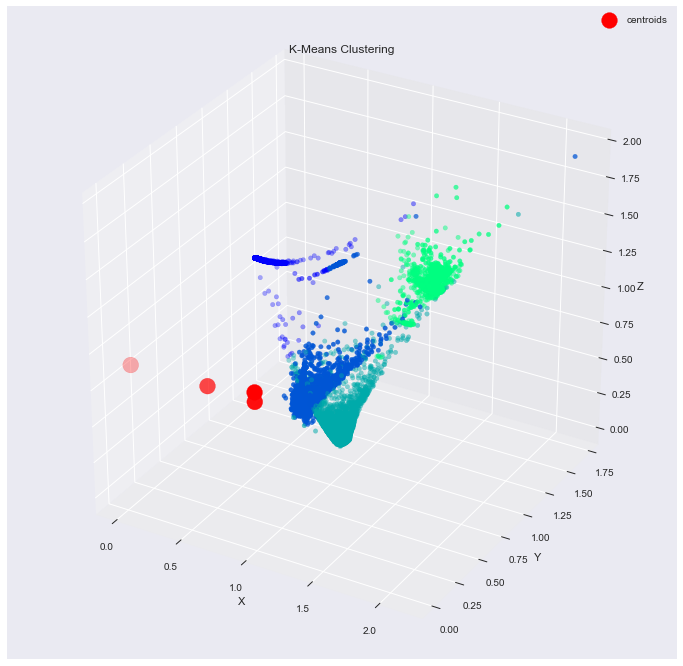

In [163]:
#Plot the clusters obtained using k means
# https://thatascience.com/learn-machine-learning/kmeans/
fig = plt.figure(1, figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot Cluster Centroids
scatter = ax.scatter(km.cluster_centers_[:, 0], # get 1st N of each row
                     km.cluster_centers_[:, 1],
                     km.cluster_centers_[:, 2],
                     s = 250, 
                     marker='o', 
                     c='red', 
                     label='centroids')

# Plot Cluster X, Y, Z points
scatter = ax.scatter(kmeans_data[:, 0], 
                     kmeans_data[:, 1], 
                     kmeans_data[:, 2],
                     c=clusters, 
                     s=20, 
                     cmap='winter')

ax.set_title('K-Means Clustering')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


In [164]:
data = list( zip(paper_id, clusters) )
data[0:5]

[('000a9d20ef42c288254c8e631056693b8e3b5498', 0),
 ('000b7d1517ceebb34e1e3e817695b6de03e2fa78', 1),
 ('0012e9e7414d62c560dd8da14415c4803fc8674e', 0),
 ('00142f93c18b07350be89e96372d240372437ed9', 2),
 ('0015023cc06b5362d332b3baf348d11567ca2fbb', 1)]

In [165]:
paper_id = df['paper_id'].values
data = list( zip(paper_id, clusters) )
labeld_df = pd.DataFrame(columns=['paper_id', 'cluster'], data=data)
labeld_df.head()

,paper_id,cluster
0,000a9d20ef42c288254c8e631056693b8e3b5498,0
1,000b7d1517ceebb34e1e3e817695b6de03e2fa78,1
2,0012e9e7414d62c560dd8da14415c4803fc8674e,0
3,00142f93c18b07350be89e96372d240372437ed9,2
4,0015023cc06b5362d332b3baf348d11567ca2fbb,1


In [166]:
labeld_df.to_csv(data_dir+"paper_kmeans_clusters.csv")